# Bibliotecas

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import  to_categorical
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier


# Ignorar Avisos desnecessários
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Confere se temos GPU instalada

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.experimental.list_physical_devices())

Num GPUs Available:  1


# Funções Auxiliares

In [3]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def min_max(serie):
    min = serie.min()
    max = serie.max()
    return serie.apply(lambda x: (x-min)/(max-min))

# Análise dos Dados

## Carregando a base de dados

In [140]:
df = pd.read_csv("./data/heart.csv")

In [141]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [143]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [144]:
round(df.groupby('target').count().age / df.shape[0] * 100, 2)

target
0    45.54
1    54.46
Name: age, dtype: float64

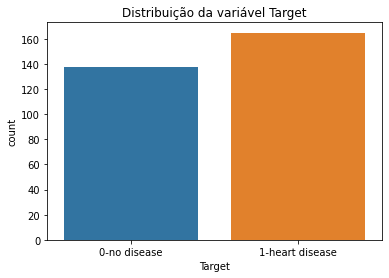

In [145]:
sns.countplot(df.target)
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks(ticks=range(0,2), labels=['0-no disease', '1-heart disease'])
plt.show()

In [146]:
fig = px.scatter_matrix(df, dimensions=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"], color="target")
fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.update_layout(title='Iris Data set', width=1200, height=1200)
fig.show()

In [147]:
corr = df.iloc[:,0:13].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
age,1.00,-0.10,-0.07,0.28,0.21,0.12,-0.12,-0.40,0.10,0.21,-0.17,0.28,0.07
sex,-0.10,1.00,-0.05,-0.06,-0.20,0.05,-0.06,-0.04,0.14,0.10,-0.03,0.12,0.21
cp,-0.07,-0.05,1.00,0.05,-0.08,0.09,0.04,0.30,-0.39,-0.15,0.12,-0.18,-0.16
trestbps,0.28,-0.06,0.05,1.00,0.12,0.18,-0.11,-0.05,0.07,0.19,-0.12,0.10,0.06
chol,0.21,-0.20,-0.08,0.12,1.00,0.01,-0.15,-0.01,0.07,0.05,-0.00,0.07,0.10
fbs,0.12,0.05,0.09,0.18,0.01,1.00,-0.08,-0.01,0.03,0.01,-0.06,0.14,-0.03
restecg,-0.12,-0.06,0.04,-0.11,-0.15,-0.08,1.00,0.04,-0.07,-0.06,0.09,-0.07,-0.01
thalach,-0.40,-0.04,0.30,-0.05,-0.01,-0.01,0.04,1.00,-0.38,-0.34,0.39,-0.21,-0.10
exang,0.10,0.14,-0.39,0.07,0.07,0.03,-0.07,-0.38,1.00,0.29,-0.26,0.12,0.21
oldpeak,0.21,0.10,-0.15,0.19,0.05,0.01,-0.06,-0.34,0.29,1.00,-0.58,0.22,0.21


## Vamos retirar três variáveis que estão muito correlacionadas com as outras: "thalach", "exang" e "slope"

In [148]:
df.drop(['thalach', 'exang', 'slope'], axis=1, inplace=True)

### Padronizando os dados com a função Min-Max apenas nas colunas que precisam de ajuste 
### Dados finais entre zero e 1

In [167]:
X = df.iloc[:,0:11].copy()
X.age = min_max(X.age)
X.trestbps = min_max(X.trestbps)
X.chol = min_max(X.chol)
#X.thalach = min_max(X.thalach)
X = X.to_numpy()
X[:5]

array([[0.70833333, 1.        , 3.        , 0.48113208, 0.24429224,
        1.        , 0.        , 2.3       , 0.        , 1.        ,
        1.        ],
       [0.16666667, 1.        , 2.        , 0.33962264, 0.28310502,
        0.        , 1.        , 3.5       , 0.        , 2.        ,
        1.        ],
       [0.25      , 0.        , 1.        , 0.33962264, 0.17808219,
        0.        , 0.        , 1.4       , 0.        , 2.        ,
        1.        ],
       [0.5625    , 1.        , 1.        , 0.24528302, 0.25114155,
        0.        , 1.        , 0.8       , 0.        , 2.        ,
        1.        ],
       [0.58333333, 0.        , 0.        , 0.24528302, 0.52054795,
        0.        , 1.        , 0.6       , 0.        , 2.        ,
        1.        ]])

In [168]:
num_features = X.shape[1]
X.shape

(303, 11)

In [169]:
y = df.target.to_numpy()
y.shape

(303,)

### Dividindo a Base de Dados entre Treino e Teste, com 20% para os testes.

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
X_train.shape

(242, 11)

In [172]:
y_train.shape

(242,)

# Modelo de MLP

## Criando o modelo

In [173]:
model = Sequential()
model.add(Dense(13, input_dim=num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1 , activation='sigmoid'))
print(model.summary())

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 13)                156       
_________________________________________________________________
dropout_60 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 7)                 98        
_________________________________________________________________
dropout_61 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 8         
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________
None


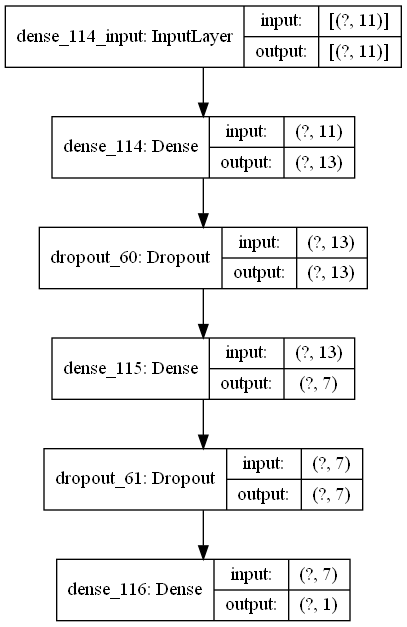

In [174]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Compilando e treinando o modelo. 
### Vamos utilizar a função de Callback ModelCheckPointer para salvar o modelo com a melhor accuracia na base de validação (que é a mesma de teste final pois temos uma base muito pequena)

In [175]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [176]:
%%time
checkpointer = ModelCheckpoint(filepath='./modelo_mlp_ex3_2.hdf5', verbose=1,  save_best_only=True, monitor='val_accuracy')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=64, callbacks=[checkpointer])

Epoch 1/300
1/4 [======>.......................] - ETA: 0s - loss: 0.7824 - accuracy: 0.3750
Epoch 00001: val_accuracy improved from -inf to 0.31148, saving model to .\modelo_mlp_ex3_2.hdf5
4/4 [==============================] - 0s 44ms/step - loss: 0.8435 - accuracy: 0.3884 - val_loss: 0.7853 - val_accuracy: 0.3115
Epoch 2/300
1/4 [======>.......................] - ETA: 0s - loss: 0.8326 - accuracy: 0.3438
Epoch 00002: val_accuracy did not improve from 0.31148
4/4 [==============================] - 0s 6ms/step - loss: 0.8402 - accuracy: 0.3347 - val_loss: 0.7708 - val_accuracy: 0.3115
Epoch 3/300
1/4 [======>.......................] - ETA: 0s - loss: 0.8219 - accuracy: 0.3281
Epoch 00003: val_accuracy improved from 0.31148 to 0.34426, saving model to .\modelo_mlp_ex3_2.hdf5
4/4 [==============================] - 0s 12ms/step - loss: 0.7757 - accuracy: 0.4215 - val_loss: 0.7563 - val_accuracy: 0.3443
Epoch 4/300
1/4 [======>.......................] - ETA: 0s - loss: 0.7251 - accuracy: 

## Gráfico comparativo de Acurácia e Perda no treinamento

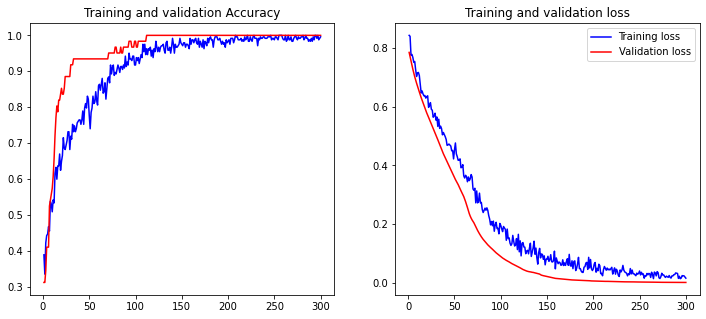

In [177]:
plot_history(history)

## Carregando o melhor modelo salvo e apresentando a acurácia do Treino e do Teste

In [178]:
model = load_model("./modelo_mlp_ex3_2.hdf5")

In [179]:
scores = model.evaluate(X_train, y_train)
print()
print(f"Acuracia do Treino: {round(scores[1]*100,2)}%")

8/8 [==============================] - 0s 1ms/step - loss: 0.0621 - accuracy: 0.9959

Acuracia do Treino: 99.59%


In [180]:
scores = model.evaluate(X_test, y_test)
print()
print(f"Acuracia da Validação: {round(scores[1]*100,2)}%")

2/2 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 1.0000

Acuracia da Validação: 100.0%


## Conferindo o modelo final com uma Validação Cruzada (Cross Validation) usando 10 amostras. Neste caso vamos usar toda a base de dados.

In [181]:
def create_model():
    model = Sequential()
    model.add(Dense(13, input_dim=num_features, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1 , activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    

In [184]:
warnings.simplefilter(action='ignore')

estimator = KerasClassifier(build_fn=create_model, epochs=300, batch_size=64, verbose=0)
scores = cross_val_score(estimator, X, y, cv=10, n_jobs=1)
print()
print("Accuracy : {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std()))


Accuracy : 1.00 (+/- 0.00)
